In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:34221' processes=5 threads=90, memory=419.10 GiB>

# Load modules

In [4]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [6]:
lim_varnames = [
    "sp_Fe_lim_Cweight_avg_100m",
    "sp_N_lim_Cweight_avg_100m",
    "sp_P_lim_Cweight_avg_100m",
    "diat_Fe_lim_Cweight_avg_100m",
    "diat_N_lim_Cweight_avg_100m",
    "diat_P_lim_Cweight_avg_100m",
    "diat_SiO3_lim_Cweight_avg_100m",
]

cfgs = {}

for varname in lim_varnames:
    cfg = CESM2_config()
    cfg.year_s = 1850
    cfg.year_e = 2024
    cfg.setvar(varname)

    cfgs[varname] = cfg


if cfgs[varname].comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')



In [9]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

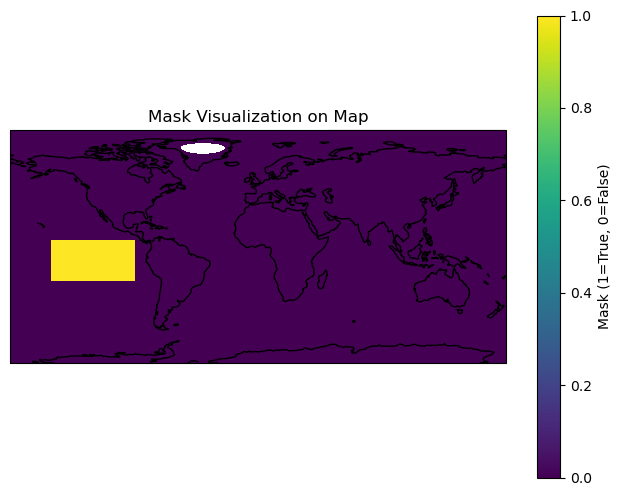

In [10]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [11]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

exceptcv = [
    'time', 'lon', 'lat', 'lev', 'TLONG', 'TLAT', 'z_w',
] + [cfg.var for cfg in cfgs.values()]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))

    # area = ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * area).sum(dim=['nlat','nlon'], skipna=True)
    # effective_area = area.where(ds[varname].notnull()).sum(dim=['nlat','nlon'], skipna=True)
    # ds[varname] = weighted_sum / effective_area
    
    volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfgs[varname].year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfgs[varname].year_e+1, 1, 1)

In [13]:
# Read LE dataset


import datetime
import numpy as np
import xarray as xr

start_time = time.time()

for varname, cfg in cfgs.items():
    
    
    # variable name
    dname = cfg.var

    # load LE file paths
    cfg.LE_path_load(dname)

    # open LE dataset
    cfg.LE_ds = xr.open_mfdataset(
        cfg.LE_file_list[0],
        chunks={'time': 12},
        combine='nested',
        concat_dim=[[*cfg.LE_ensembles], 'time'],
        parallel=True,
        preprocess=lambda ds, dname=dname: process_coords(
            dname, mask, ds_grid_sub, ds, start_date, end_date
        ),
        decode_cf=True,
        decode_times=True,
    )

    # rename ensemble dimension
    cfg.LE_ds = cfg.LE_ds.rename({"concat_dim": "ens_LE"})

    # shift time coordinate (mid-month correction)
    new_time = cfg.LE_ds.time - np.array(
        [datetime.timedelta(days=15)] * cfg.LE_ds.sizes["time"]
    )
    cfg.LE_ds = cfg.LE_ds.assign_coords(time=new_time)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading LE: ' + str(elapsed_time))





elasped time for reading LE: 305.0877683162689
elasped time for reading LE: 612.8362741470337
elasped time for reading LE: 921.1268064975739
elasped time for reading LE: 1231.4935290813446
elasped time for reading LE: 1539.8265280723572
elasped time for reading LE: 2165.2955672740936
elasped time for reading LE: 2506.4008598327637


In [14]:
import time
import os
import xarray as xr

# --------------------------------------------------
# Start timer
# --------------------------------------------------
start_time = time.time()

# --------------------------------------------------
# Create a composite dataset from all variables
# stored in cfgs
# --------------------------------------------------
comp_dataset = xr.Dataset()

for varname, cfg in cfgs.items():
    # Use the actual CESM variable name (cfg.var)
    # as the variable name in the composite dataset
    comp_dataset[cfg.var] = cfg.LE_ds[cfg.var]

# --------------------------------------------------
# (Optional) Define spatial mask
# Note: This is only needed if masking was not
# already applied during preprocessing
# --------------------------------------------------
mask = (
    (ds.TLONG >= cut_grid_info["lonw"]) &
    (ds.TLONG <= cut_grid_info["lone"]) &
    (ds.TLAT  >= cut_grid_info["lats"]) &
    (ds.TLAT  <= cut_grid_info["latn"])
)

# --------------------------------------------------
# Define output NetCDF filename
# --------------------------------------------------
filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_lims_"
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

# --------------------------------------------------
# Write NetCDF file
# --------------------------------------------------
if os.path.exists(filename):
    os.remove(filename)

comp_dataset.to_netcdf(filename, mode="w")

# --------------------------------------------------
# End timer and report elapsed time
# --------------------------------------------------
elapsed_time = time.time() - start_time
print(f"Elapsed time for writing NetCDF: {elapsed_time:.2f} s")


Elapsed time for writing NetCDF: 3950.32 s


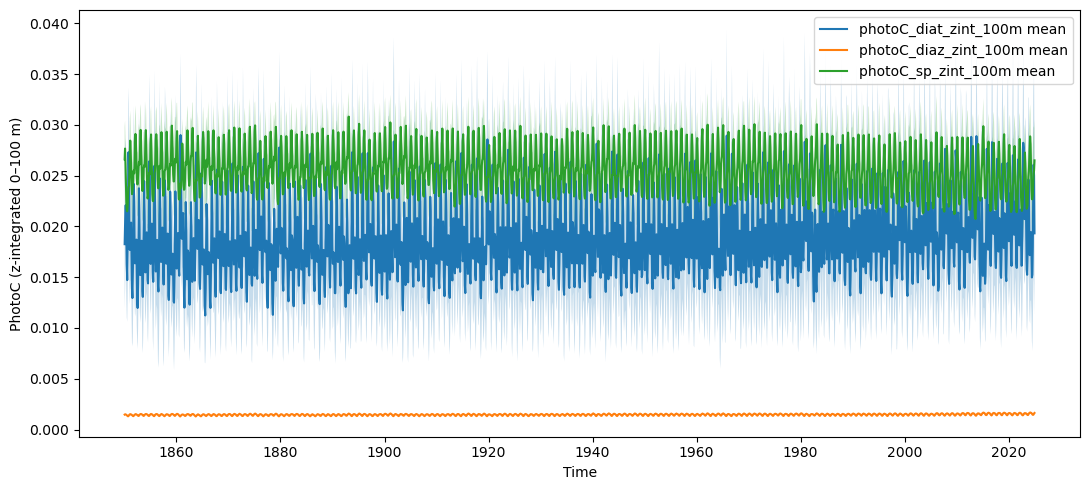

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd





filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_PPs_"
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

ds = xr.open_dataset(filename)
time_pd = pd.to_datetime(ds['time'].values.astype(str))

vars_photoC = [
    "photoC_diat_zint_100m",
    "photoC_diaz_zint_100m",
    "photoC_sp_zint_100m",
]


plt.figure(figsize=(11,5))

for v in vars_photoC:
    da = ds[v]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(time_pd, mean, label=f"{v} mean")
    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        alpha=0.25
    )

plt.xlabel("Time")
plt.ylabel("PhotoC (z-integrated 0–100 m)")
plt.legend()
plt.tight_layout()
plt.show()



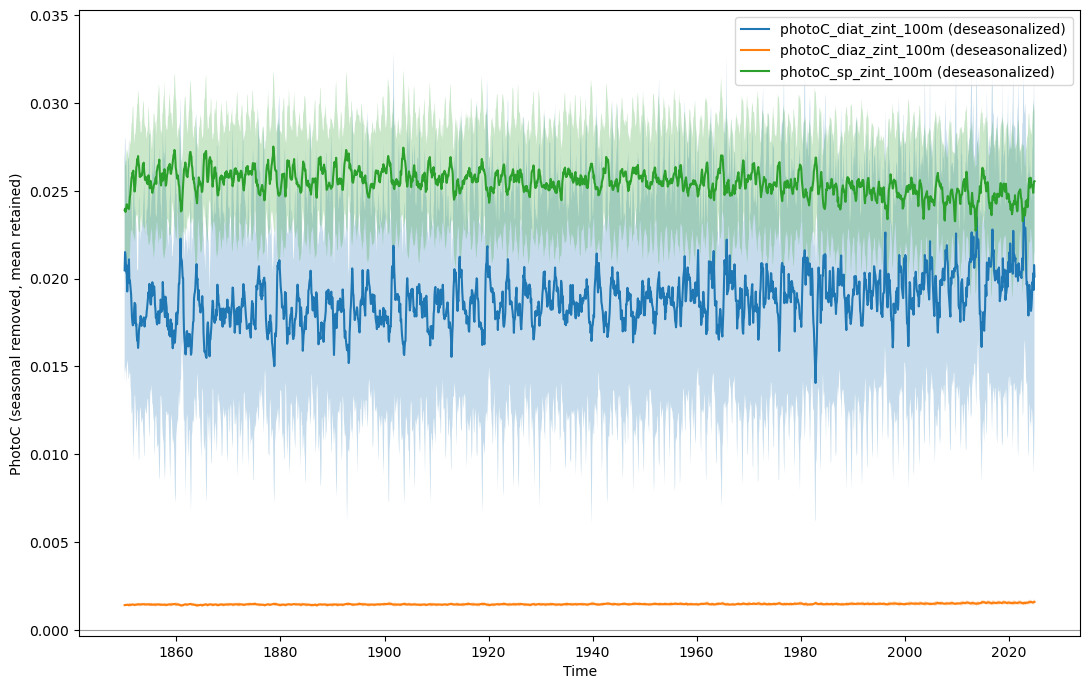

In [21]:
plt.figure(figsize=(11,7))

for v in vars_photoC:
    da = ds[v]   # dims: ens_LE, time

    # 1) Member-wise overall mean (유지할 mean)
    mean_all = da.mean("time")

    # 2) Monthly climatology (mean + seasonal cycle)
    clim = da.groupby("time.month").mean("time")

    # 3) Seasonal-cycle-only component
    seasonal = clim - mean_all

    # 4) Remove ONLY seasonal cycle
    da_deseason = da.groupby("time.month") - seasonal

    # 5) Ensemble statistics
    ens_mean = da_deseason.mean("ens_LE")
    ens_std  = da_deseason.std("ens_LE")

    plt.plot(time_pd, ens_mean, label=f"{v} (deseasonalized)")
    plt.fill_between(
        time_pd,
        ens_mean - ens_std,
        ens_mean + ens_std,
        alpha=0.25
    )

plt.axhline(0, color="k", lw=0.8, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("PhotoC (seasonal removed, mean retained)")
plt.legend()
plt.tight_layout()
plt.show()


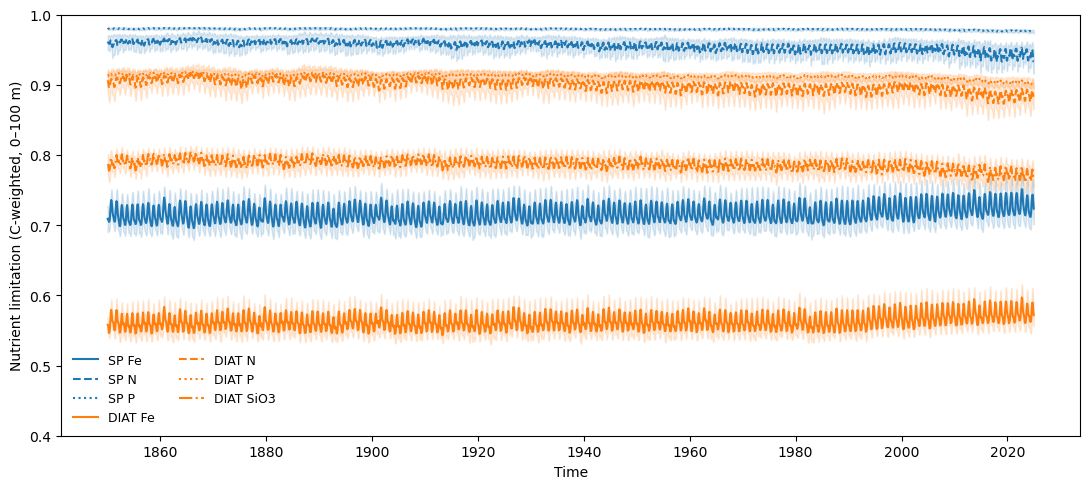

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------------------------------
# Load dataset
# --------------------------------------------------
filename_lims = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/"
    "LIM_input_LE_lims_x1_210_x2_270_y1_-20_y2_10.nc"
)

ds = xr.open_dataset(filename_lims)

# Convert cftime -> pandas datetime
time_pd = pd.to_datetime(ds["time"].values.astype(str))

# --------------------------------------------------
# Variable groups (correct names)
# --------------------------------------------------
sp_vars = {
    "sp_Fe_lim_Cweight_avg_100m":  {"nutrient": "Fe"},
    "sp_N_lim_Cweight_avg_100m":   {"nutrient": "N"},
    "sp_P_lim_Cweight_avg_100m":   {"nutrient": "P"},
}

diat_vars = {
    "diat_Fe_lim_Cweight_avg_100m":   {"nutrient": "Fe"},
    "diat_N_lim_Cweight_avg_100m":    {"nutrient": "N"},
    "diat_P_lim_Cweight_avg_100m":    {"nutrient": "P"},
    "diat_SiO3_lim_Cweight_avg_100m": {"nutrient": "SiO3"},
}

# --------------------------------------------------
# Style definitions
# --------------------------------------------------
colors = {
    "SP": "tab:blue",
    "DIAT": "tab:orange",
}

linestyles = {
    "Fe": "-",
    "N": "--",
    "P": ":",
    "SiO3": "-.",
}

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(11, 5))

# ---- SP terms ----
for v, info in sp_vars.items():
    da = ds[v]  # dims: ens_LE, time

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(
        time_pd,
        mean,
        color=colors["SP"],
        linestyle=linestyles[info["nutrient"]],
        label=f"SP {info['nutrient']}"
    )

    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=colors["SP"],
        alpha=0.15
    )

# ---- DIAT terms ----
for v, info in diat_vars.items():
    da = ds[v]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(
        time_pd,
        mean,
        color=colors["DIAT"],
        linestyle=linestyles[info["nutrient"]],
        label=f"DIAT {info['nutrient']}"
    )

    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=colors["DIAT"],
        alpha=0.15
    )

# --------------------------------------------------
# Axes / legend
# --------------------------------------------------
plt.ylim(0.4, 1.0)
plt.xlabel("Time")
plt.ylabel("Nutrient limitation (C-weighted, 0–100 m)")

plt.legend(
    ncol=2,
    frameon=False,
    fontsize=9
)

plt.tight_layout()
plt.show()


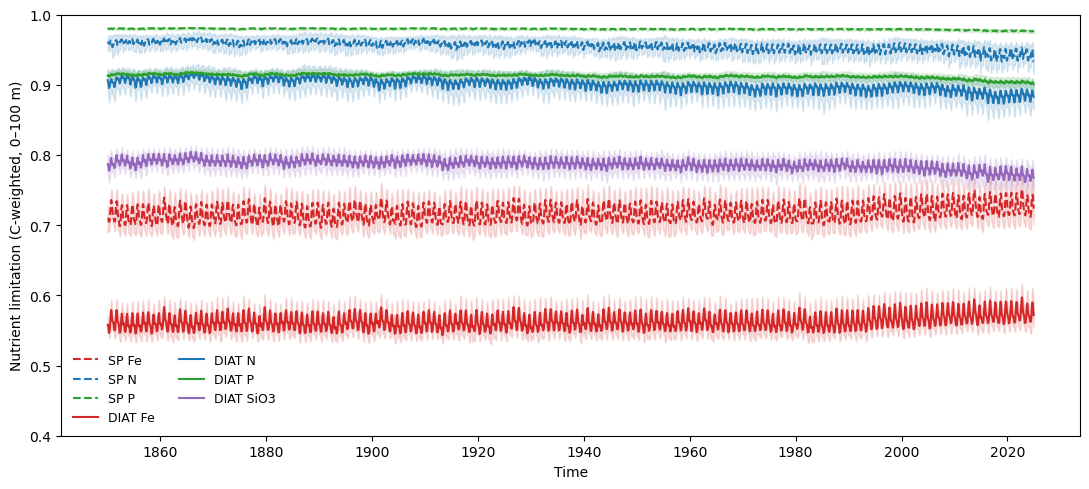

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------------------------------
# Load dataset
# --------------------------------------------------
filename_lims = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/"
    "LIM_input_LE_lims_x1_210_x2_270_y1_-20_y2_10.nc"
)

ds = xr.open_dataset(filename_lims)

# Convert cftime -> pandas datetime
time_pd = pd.to_datetime(ds["time"].values.astype(str))

# --------------------------------------------------
# Variable groups (correct names)
# --------------------------------------------------
sp_vars = [
    "sp_Fe_lim_Cweight_avg_100m",
    "sp_N_lim_Cweight_avg_100m",
    "sp_P_lim_Cweight_avg_100m",
]

diat_vars = [
    "diat_Fe_lim_Cweight_avg_100m",
    "diat_N_lim_Cweight_avg_100m",
    "diat_P_lim_Cweight_avg_100m",
    "diat_SiO3_lim_Cweight_avg_100m",
]

# --------------------------------------------------
# Style definitions
# --------------------------------------------------
nutrient_colors = {
    "Fe":   "tab:red",
    "N":    "tab:blue",
    "P":    "tab:green",
    "SiO3": "tab:purple",
}

linestyles = {
    "SP":   "--",
    "DIAT": "-",
}

# Helper to infer nutrient name from variable string
def get_nutrient(varname):
    if "Fe" in varname:
        return "Fe"
    elif "_N_" in varname:
        return "N"
    elif "_P_" in varname:
        return "P"
    elif "SiO3" in varname:
        return "SiO3"
    else:
        raise ValueError(f"Unknown nutrient in {varname}")

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(11, 5))

# ---- SP terms (dashed) ----
for v in sp_vars:
    da = ds[v]

    nutrient = get_nutrient(v)
    color = nutrient_colors[nutrient]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(
        time_pd,
        mean,
        color=color,
        linestyle=linestyles["SP"],
        label=f"SP {nutrient}"
    )

    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=color,
        alpha=0.15
    )

# ---- DIAT terms (solid) ----
for v in diat_vars:
    da = ds[v]

    nutrient = get_nutrient(v)
    color = nutrient_colors[nutrient]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(
        time_pd,
        mean,
        color=color,
        linestyle=linestyles["DIAT"],
        label=f"DIAT {nutrient}"
    )

    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=color,
        alpha=0.15
    )

# --------------------------------------------------
# Axes / legend
# --------------------------------------------------
plt.ylim(0.4, 1.0)
plt.xlabel("Time")
plt.ylabel("Nutrient limitation (C-weighted, 0–100 m)")

plt.legend(
    ncol=2,
    frameon=False,
    fontsize=9
)

plt.tight_layout()
plt.show()


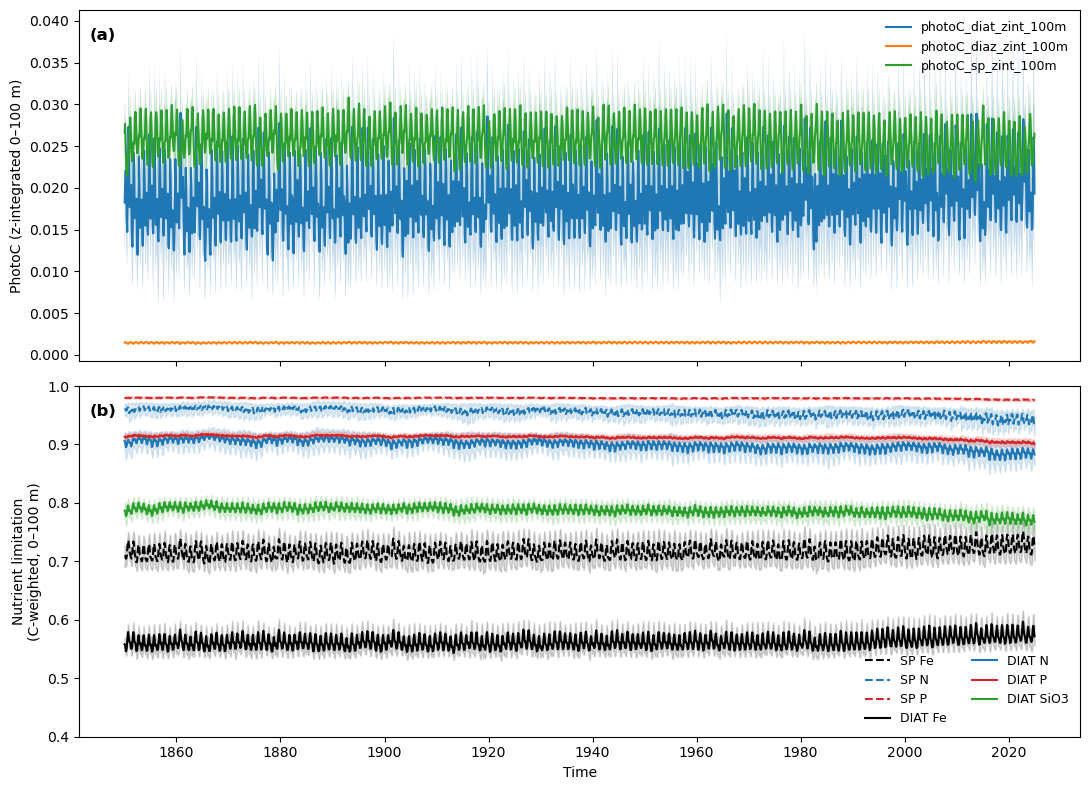

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# ==================================================
# Load PhotoC dataset (upper panel)
# ==================================================
filename_pp = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_PPs_"
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

ds_pp = xr.open_dataset(filename_pp)
time_pd = pd.to_datetime(ds_pp["time"].values.astype(str))

vars_photoC = [
    "photoC_diat_zint_100m",
    "photoC_diaz_zint_100m",
    "photoC_sp_zint_100m",
]

# ==================================================
# Load nutrient limitation dataset (lower panel)
# ==================================================
filename_lims = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/"
    "LIM_input_LE_lims_x1_210_x2_270_y1_-20_y2_10.nc"
)

ds_lims = xr.open_dataset(filename_lims)

sp_vars = [
    "sp_Fe_lim_Cweight_avg_100m",
    "sp_N_lim_Cweight_avg_100m",
    "sp_P_lim_Cweight_avg_100m",
]

diat_vars = [
    "diat_Fe_lim_Cweight_avg_100m",
    "diat_N_lim_Cweight_avg_100m",
    "diat_P_lim_Cweight_avg_100m",
    "diat_SiO3_lim_Cweight_avg_100m",
]

# ==================================================
# Plot settings
# ==================================================
nutrient_colors = {
    "Fe":   "black",
    "N":    "tab:blue",
    "P":    "tab:red",
    "SiO3": "tab:green",
}

linestyles = {
    "SP":   "--",
    "DIAT": "-",
}

def get_nutrient(varname):
    if "Fe" in varname:
        return "Fe"
    elif "_N_" in varname:
        return "N"
    elif "_P_" in varname:
        return "P"
    elif "SiO3" in varname:
        return "SiO3"
    else:
        raise ValueError(f"Unknown nutrient in {varname}")

# ==================================================
# Create figure and axes
# ==================================================
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11, 8),
    sharex=True
)

# ==================================================
# (a) Upper panel: PhotoC
# ==================================================
for v in vars_photoC:
    da = ds_pp[v]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    ax1.plot(time_pd, mean, label=v)
    ax1.fill_between(
        time_pd,
        mean - std,
        mean + std,
        alpha=0.25
    )

ax1.set_ylabel("PhotoC (z-integrated 0–100 m)")
ax1.legend(frameon=False, fontsize=9)
ax1.text(0.01, 0.95, "(a)", transform=ax1.transAxes,
         fontsize=12, fontweight="bold", va="top")

# ==================================================
# (b) Lower panel: Nutrient limitation
# ==================================================
# SP (dashed)
for v in sp_vars:
    da = ds_lims[v]
    nutrient = get_nutrient(v)
    color = nutrient_colors[nutrient]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    ax2.plot(
        time_pd, mean,
        color=color,
        linestyle=linestyles["SP"],
        label=f"SP {nutrient}"
    )
    ax2.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=color,
        alpha=0.15
    )

# DIAT (solid)
for v in diat_vars:
    da = ds_lims[v]
    nutrient = get_nutrient(v)
    color = nutrient_colors[nutrient]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    ax2.plot(
        time_pd, mean,
        color=color,
        linestyle=linestyles["DIAT"],
        label=f"DIAT {nutrient}"
    )
    ax2.fill_between(
        time_pd,
        mean - std,
        mean + std,
        color=color,
        alpha=0.15
    )

ax2.set_ylim(0.4, 1.0)
ax2.set_ylabel("Nutrient limitation\n(C-weighted, 0–100 m)")
ax2.set_xlabel("Time")

ax2.legend(
    ncol=2,
    frameon=False,
    fontsize=9
)

ax2.text(0.01, 0.95, "(b)", transform=ax2.transAxes,
         fontsize=12, fontweight="bold", va="top")

# ==================================================
# Final layout
# ==================================================
plt.tight_layout()
plt.show()
